# Introduction to Laser Learning Environment (LLE)
`lle` is a python package aimed at multi-agent reinforcement learning. The notebook gives an overview of the `LLE` class, designed for that purpose. 
The `LLE` class complies with the `RLEnv` *interface* from the `rlenv` package.

A more fine-grained control can be obtained by using the `World` class.

## 1. How to install
`lle` is written in Rust and requires the rust compiler to be installed.
Enter the following instructions in a terminal:
```bash
curl --proto '=https' --tlsv1.2 -sSf https://sh.rustup.rs | sh
pip install "git+https://github.com/yamoling/rlenv.git"
pip install laser-learning-environment
pip install matplotlib
```

This installs and compile the Laser Learning Environment and its dependencies, in the `lle` folder. Move this notebook to this folder, and restart jupyter. After this operation, you should be able to import `lle` in this notebook: 

In [2]:
from lle import LLE

If it works, you are ready to go !

In order to display the environment, we will use some functions from the package `matplotlib`. Some other available examples use the package `cv2`. Change the variable $display$ to $False$ if you do not want this notebook to display the boards.

In [3]:
import matplotlib.pyplot as plt

## 2. Loading maps
### 2.1 Standard levels
LLE defines standard levels from 1 to 6 that can be loaded with `LLE.level(n)`.

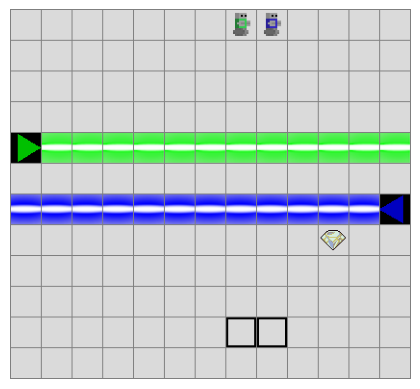

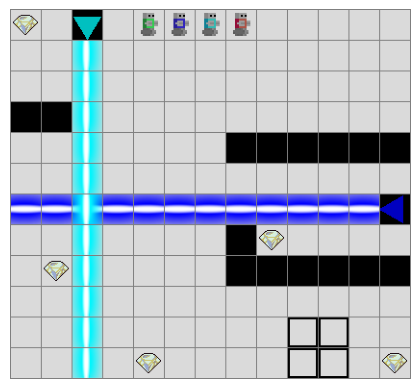

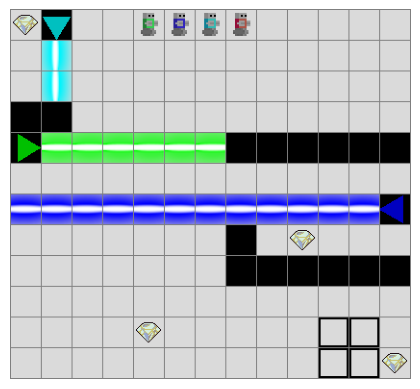

In [4]:
def display(env: LLE):
    plt.imshow(env.render("rgb_array"))
    plt.axis('off')
    plt.show()

for lvl in [4, 5, 6]:
    env = LLE.level(lvl)
    display(env)

### 2.2 Custom boards
For the sake of this notebook, we create a small custom board.
Refer to the notebook `world_introduction.pynb` for more details on how to create your own boards.

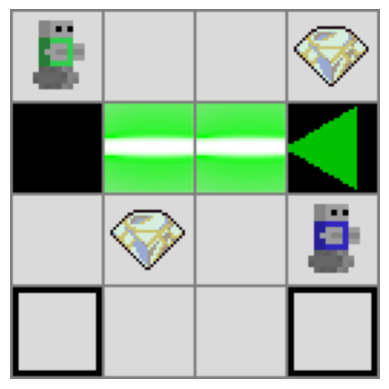

In [5]:
env = LLE.from_str(
    """
S0 . . G
 @ . . L0W
 . G . S1
 X . . X
"""
)
display(env)

## 3. Playing the game
The objective of LLE is for the team of agents to collect all the gems on the board then reach the exit tiles. When an agent has reached an exit, it can not move anymore. The game ends when all the agents have reached an exit.

### 3.1 Observations
An observation of the environment refers to the information that agents receive as input. An observation contains:
- the actual observation data as a numpy array (one per agent)
- some extras such as agent ids, time step, previous actions, etc. (one per agent, nothing in this case)
- the state of the environment as a numpy array (useful for algorithms such as QMix)
- the available actions (one-hot encoding)

In [6]:
initial_observation = env.reset()
print("Observation shape", initial_observation.data.shape)
print("Extras shape", initial_observation.extras_shape)
print("State shape", initial_observation.state.shape)
print("Available actions:\n", initial_observation.available_actions)

Observation shape (2, 112)
Extras shape (2, 0)
State shape (6,)
Available actions:
 [[0 0 1 0 1]
 [0 1 0 1 1]]


#### Extras
We could also add some extra information to the observation such as the ID of each agent and a time limit of 20 steps. For this, we can use the `rlenv.Builder`. This does not change the way the environment is rendered, but adds extra information to the observation (`agent_id`) or changes the behaviour of the environment (`time_limit`).

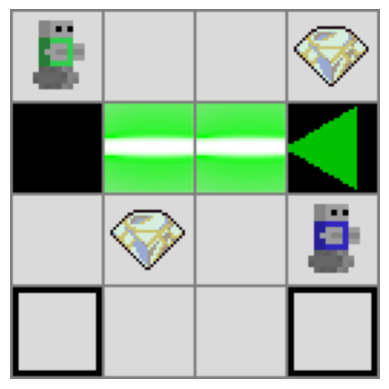

Observation shape (2, 112)
Extras with agent ID [[1. 0.]
 [0. 1.]]
State shape (6,)
Available actions:
 [[0 0 1 0 1]
 [0 1 0 1 1]]


In [15]:
import rlenv

env = (rlenv.Builder(LLE.from_str(
    """
S0 . . G
 @ . . L0W
 . G . S1
 X . . X
"""
    ))
    .agent_id()
    .time_limit(5)
    .build())
display(env)
obs = env.reset()
print("Observation shape", obs.data.shape)
print("Extras with agent ID", obs.extras)
print("State shape", obs.state.shape)
print("Available actions:\n", obs.available_actions)

### 3.2 Actions
The action space is discrete and there are 5 actions available defined in `Action.py`: North, South, East, West and Stay. 
When using the `LLE` class, actions should be referred to as integers from 0 to 4, where the integer refers to the value of the action in the `Action` enum class.

In [8]:
from lle import Action

step_data = env.step([Action.EAST.value, Action.WEST.value])
# Unpack the tuple
obs, reward, done, truncated, info = step_data
# Or access it via properties
reward = step_data.reward
display(env)

AttributeError: 'tuple' object has no attribute 'reward'


#### Action loop

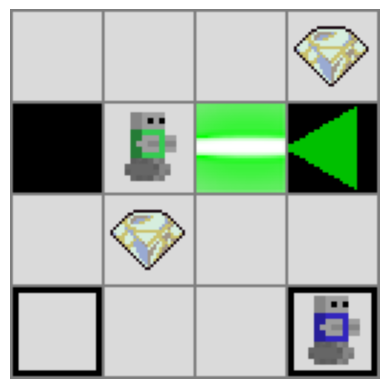

In [16]:
import numpy as np
import random
terminated = False
obs = env.reset()
while not terminated:
    available_actions = [np.nonzero(available)[0] for available in obs.available_actions]
    actions = [random.choice(agent_actions) for agent_actions in available_actions]
    obs, r, done, truncated, info = env.step(actions)
    terminated = done or truncated
display(env)

## 4. Others
### 4.1 Setting the state
You can force the state of the environment with `env.set_state(state)` where `state` is a `WorldState`.